In [1]:
import numpy as np

from finquant.portfolio import *
from finquant.moving_average import compute_ma, ema

import pandas as pd
import datetime

import yfinance as yf

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import black_litterman, risk_models
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier, objective_functions

import riskfolio.Portfolio as pf

import matplotlib as plt
import matplotlib.pyplot as pyplt

import statsmodels .api  as  sm 
from sklearn.linear_model  import  LinearRegression
import cvxpy  as  cv
from scipy.stats import norm

In [2]:
df_health = pd.read_csv('tick_score_health.csv')
df_tech = pd.read_csv('tick_score_tech.csv')
df_durable = pd.read_csv('tick_score_durable.csv')
df_nondurable = pd.read_csv('tick_score_nondurable.csv')
df_capital = pd.read_csv('tick_score_capital.csv')
df_transport = pd.read_csv('tick_score_transport.csv')
df_util = pd.read_csv('tick_score_util.csv')
df_services = pd.read_csv('tick_score_services.csv')
df_energy = pd.read_csv('tick_score_energy.csv')
df_finance = pd.read_csv('tick_score_finance.csv')
df_basics = pd.read_csv('tick_score_basics.csv')


frames = [df_finance, df_capital, df_durable, df_energy, df_health, df_nondurable, df_services, df_tech, df_services, df_util, df_basics]
df = pd.concat(frames)
df = df.drop_duplicates(subset=['Unnamed: 0'], keep='last')
df = df.set_index("Unnamed: 0")

percentile = np.percentile(df['Score'], 90)
mu, std = norm.fit(df['Score'])
roc = std / 3
aplus = df[df['Score'] > mu + (roc*4)]
#aplus = df[df['Score'] > mu + (roc*6)]
tickers = list(aplus.index)

In [3]:
start = "2016-01-01"
end = "2019-12-30"
future_end = "2020-12-30"

In [4]:
# Tickers of assets
assets = list(tickers)
assets.sort()

In [5]:
data = yf.download(assets, start = start, end = end, threads = False)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

market_data = yf.download("^GSPC", start = start, end=end, threads = False)
market_data = market_data.loc[:,('Adj Close')]

[*********************100%***********************]  48 of 48 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
port_diff = data[assets].pct_change().dropna()
mkt_diff = market_data.pct_change().dropna()

In [7]:
# Monte Carlo Alone
pf = build_portfolio(names=tickers, start_date = start, end_date = end, data_api="yfinance", )
opt_w, opt_res = pf.mc_optimisation(num_trials=5000)      # Monte Carlo weights and results
weights = pd.DataFrame(opt_w.loc["Max Sharpe Ratio"])
weights = weights.reset_index()
weights.columns = ["Name", "Allocation"]
pf2 = build_portfolio(names=tickers, start_date = start, end_date = end, data_api="yfinance", pf_allocation = weights)
MC_Weights = weights.set_index("Name")

[*********************100%***********************]  48 of 48 completed


\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


[*********************100%***********************]  48 of 48 completed


In [8]:
# Time for CAPM
x = mkt_diff.values 
x = sm.add_constant(x)

Beta_1  =  [] 
for i in assets:
    y_i =  port_diff[i].values 
    mod =  sm.OLS(y_i, x) 
    res =  mod.fit() 
    Beta_1.append(res.params[1])

Beta_1 = np.matrix(Beta_1)

# Using scikit learn 
y = port_diff.values 
x = mkt_diff.values
lst = []
for i in mkt_diff.values:
    lst.append([i])

x = lst
reg = LinearRegression().fit(x, y)
Beta_2 = np.matrix(reg.coef_).T

# Combining both betas to show them 
B1 = pd.DataFrame(Beta_1.T, index = assets, columns = ['Beta_1']) 
B2 = pd.DataFrame(Beta_2.T, index = assets, columns = ['Beta_2'])

B1_B2 = pd.concat([B1, B2], axis = 1)


################################################## ####################### 
# Calculating the vector of means and the matrix of covariances from 
# the CAPM model 
########### ################################################## ###########

Sigma_rm = np.matrix(np.var(mkt_diff, ddof = 1))

x = mkt_diff.values 
x = sm.add_constant(x)

mu_F_1 = []
Sigma_e_1 = []
for i in assets:
    y_i = port_diff[i].values
    mod = sm.OLS(y_i, x)
    res = mod.fit()
    error = np.matrix(y_i) - np.matrix(res.predict(x))
    mu_F_1.append(np.mean(res.predict(x), axis = 0))
    Sigma_e_1.append(np.asscalar(np.var(error.T, ddof = 1, axis = 0)))

mu_F_1 = np.matrix(mu_F_1)
Sigma_e_1 = np.diag(Sigma_e_1)
Sigma_F_1 = Beta_2.T * Sigma_rm *  Beta_2 + Sigma_e_1

x = mkt_diff.values
lst = []
for i in mkt_diff.values:
    lst.append([i])

x = lst
error_2 = y - reg.predict(x)

mu_F_2 = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_e_2 = np.diag(np.var(error_2, ddof = 1, axis = 0))
Sigma_F_2 = Beta_2.T * Sigma_rm *  Beta_2 + Sigma_e_2

################################################## ###################### 
# Calculating optimal portfolios with historical estimates 
# and CAPM estimates 
############# ################################################## #########

# Defining the optimization function 
def Max_Sharpe(mu, Sigma):
    w = cv.Variable((mu.shape[1], 1))
    k = cv.Variable(1)
    rf = cv.Parameter(nonneg=True)
    rf.value=0
    #defining the problem, objective function and    
    constraints = [(mu - rf)*w == 1,
                   w >= 1e-10,
                   k >= 1e-10,
                   cv.sum(w) == k]
    prob = cv.Problem(cv.Minimize(cv.quad_form(w, Sigma)), constraints)
    #solving the problem
    prob.solve(solver=cv.ECOS)

    return np.matrix(w.value/k.value)

<ipython-input-8-51d12b4eec19>:50: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  Sigma_e_1.append(np.asscalar(np.var(error.T, ddof = 1, axis = 0)))


In [9]:
mu = np.matrix(np.mean(port_diff.values, axis = 0))
Sigma = np.cov(port_diff.values.T)

w1 = Max_Sharpe(mu, Sigma)
w2 = Max_Sharpe(mu_F_2, Sigma_F_2)



Historical_Weights = pd.DataFrame(w1, index = assets, columns = ['Historical'])
CAPM_Weights = pd.DataFrame(w2, index = assets, columns = ['CAPM'])


\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\problems\problem.py:1245: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CV

In [10]:
# Fama Three
three_factor = pd.read_csv('FF_three.csv', index_col=0, header=0)/100
three_factor = three_factor.loc[start: end][:-2]
x = three_factor[['Mkt-RF', 'SMB', 'HML']].values
y = port_diff.values
reg = LinearRegression().fit(x, y)
B = np.matrix(reg.coef_).T


Sigma_F = np.cov(x.T)
error = y - reg.predict(x)
Sigma_e = np.diag(np.var(error, ddof = 1, axis = 0))

mu_fama = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_fama = B.T * Sigma_F *  B + Sigma_e_2


w_fama_three = Max_Sharpe(mu_fama, Sigma_fama)

F3_Weights = pd.DataFrame(w_fama_three, index = assets, columns = ['Fama Three'])

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)


In [11]:
five_factor = pd.read_csv('FF_five.csv', index_col=0, header=0)/100
five_factor = five_factor.loc[start: end][:-2]
x = five_factor[['Mkt-RF', 'SMB', 'HML', 'RMW','CMA']].values
y = port_diff.values
reg = LinearRegression().fit(x, y)
B = np.matrix(reg.coef_).T

Sigma_F = np.cov(x.T)
error = y - reg.predict(x)
Sigma_e = np.diag(np.var(error, ddof = 1, axis = 0))
mu_fama = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_fama = B.T * Sigma_F *  B + Sigma_e_2
w_fama_five = Max_Sharpe(mu_fama, Sigma_fama)


F5_Weights = pd.DataFrame(w_fama_five, index = assets, columns = ['Fama Five'])


\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


In [12]:
# Black Litterman

S = risk_models.CovarianceShrinkage(data[assets]).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_data)


In [13]:
mcaps = {}
for t in assets:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]

In [14]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta, absolute_views={})

ret_bl = bl.bl_returns()
S_bl = bl.bl_cov()

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.max_sharpe()
#ef.min_volatility()
#ef.portfolio_performance(verbose=visualize)
BL_Weights = ef.clean_weights()

BL_Weights = pd.Series(BL_Weights)


C:\Apps\Anaconda3\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:247: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


In [15]:
comparisons = ["^GSPC", "WFIVX", "PRWAX", "SWPPX"]
sp_500 = yf.download(tickers=comparisons, start=start, end="2021-01-01", threads = False)
sp_500 = sp_500.loc[:,('Close')]
sp_500_total_cum_return = ((sp_500.iloc[-1] - sp_500.iloc[0]) / sp_500.iloc[0])*100
display(sp_500_total_cum_return)
sp_500_daily = sp_500.pct_change().fillna(100)[1:]
compare_port = (sp_500_daily + 1).cumprod()
compare_port *= 100
compare_port = pd.DataFrame(compare_port)
display(compare_port)

Y_cum = data[tickers].pct_change().fillna(0)[1:]
BL_port_ret = data[tickers].pct_change().fillna(0)[1:]
CAPM_port_ret = data[tickers].pct_change().fillna(0)[1:]
F3_port_ret = data[tickers].pct_change().fillna(0)[1:]
F5_port_ret = data[tickers].pct_change().fillna(0)[1:]
MC_port_ret = data[tickers].pct_change().fillna(0)[1:]

display(F3_port_ret)
display(F5_port_ret)
for tick in tickers:
    BL_port_ret.loc[:,tick] = BL_port_ret.loc[:,tick] * BL_Weights.loc[tick]
    CAPM_port_ret.loc[:,tick] = CAPM_port_ret.loc[:,tick] * CAPM_Weights.loc[tick].values
    F3_port_ret.loc[:,tick] = F3_port_ret.loc[:,tick] * F3_Weights.loc[tick].values
    F5_port_ret.loc[:,tick] = F5_port_ret.loc[:,tick] * F5_Weights.loc[tick].values
    MC_port_ret.loc[:,tick] = MC_port_ret.loc[:,tick] * MC_Weights.loc[tick].values

display(F3_port_ret)
display(F5_port_ret)

BL_port_ret = BL_port_ret.sum(axis=1)
CAPM_port_ret = CAPM_port_ret.sum(axis=1)
F3_port_ret = F3_port_ret.sum(axis=1)
F5_port_ret = F5_port_ret.sum(axis=1)
MC_port_ret = MC_port_ret.sum(axis=1)
BL_cum_ret = (((BL_port_ret + 1).cumprod()) * 100)
CAPM_cum_ret = (((CAPM_port_ret + 1).cumprod()) * 100)
F3_cum_ret = (((F3_port_ret + 1).cumprod()) * 100)
F5_cum_ret = (((F5_port_ret + 1).cumprod()) * 100)
MC_cum_ret = (((MC_port_ret + 1).cumprod()) * 100)

[*********************100%***********************]  4 of 4 completed


PRWAX    67.172198
SWPPX    84.749029
WFIVX    43.575095
^GSPC    86.622182
dtype: float64

PRWAX       SWPPX       WFIVX       ^GSPC
Date                                                      
2016-01-05   99.975533  100.193048  100.171335  100.201223
2016-01-06   99.021523   98.938224   98.914903   98.887044
2016-01-07   96.061642   96.589448   96.516273   96.543377
2016-01-08   95.009783   95.527672   95.431176   95.497004
2016-01-11   94.863008   95.624194   95.431176   95.578489
...                ...         ...         ...         ...
2020-12-24  165.166328  182.110678  143.632206  183.988354
2020-12-28  166.071423  183.687260  144.545969  185.593197
2020-12-29  166.169272  183.268981  142.547109  185.179811
2020-12-30  166.364972  183.558557  142.889778  185.428238
2020-12-31  167.172198  184.749029  143.575095  186.622182

[1258 rows x 4 columns]

MCO      SPGI       TRV       BEN       MTD       JHX  \
Date                                                                     
2016-01-05  0.013886  0.003376  0.004547 -0.001658  0.006194 -0.033225   
2016-01-06 -0.017855 -0.010934 -0.012945 -0.025471 -0.020037 -0.026823   
2016-01-07 -0.042248 -0.031463 -0.023845 -0.032102 -0.027745 -0.034453   
2016-01-08 -0.028473 -0.028643 -0.004228 -0.012328 -0.005701 -0.017841   
2016-01-11  0.008659 -0.000452  0.007548 -0.004457 -0.009779  0.002725   
...              ...       ...       ...       ...       ...       ...   
2019-12-20 -0.000252 -0.003009 -0.000293 -0.013007  0.008543  0.007618   
2019-12-23 -0.004535 -0.001068 -0.001466  0.015116 -0.004891  0.010081   
2019-12-24  0.004724  0.004164 -0.002936 -0.001909  0.001317 -0.010978   
2019-12-26  0.003695  0.003890  0.003386  0.006886  0.001910  0.002523   
2019-12-27  0.001004  0.002669  0.003742 -0.002660  0.001073  0.005536   

                  BA       HON       CLX       KMB  ...       KEP         D  \
Date                                                ...                       
2016-01-05  0.004057  0.008190  0.014448  0.020557  ...  0.012428  0.008596   
2016-01-06 -0.015879 -0.011314 -0.000472 -0.000465  ...  0.000944  0.006172   
2016-01-07 -0.041922 -0.029440 -0.010942 -0.016742  ... -0.014623  0.000584   
2016-01-08 -0.022705 -0.008062  0.004298 -0.012849  ... -0.011010  0.014743   
2016-01-11  0.001693 -0.000101  0.011888  0.003833  ...  0.031946 -0.001582   
...              ...       ...       ...       ...  ...       ...       ...   
2019-12-20 -0.016492 -0.000510  0.007790  0.009288  ...  0.000829  0.006357   
2019-12-23  0.029116  0.000113 -0.002096 -0.007536  ... -0.011599 -0.010811   
2019-12-24 -0.013480 -0.000680  0.000919  0.001898  ... -0.012573 -0.000860   
2019-12-26 -0.009249  0.003233  0.003017  0.000000  ...  0.000000  0.001229   
2019-12-27  0.000667 -0.002261  0.003858  0.006121  ...  0.003396  0.006629   

                 NGG       LNG       BCE       LYB       LIN       APD  \
Date                                                                     
2016-01-05  0.001741  0.025593  0.007282  0.005277 -0.003442 -0.017881   
2016-01-06  0.009412 -0.036652  0.003357 -0.047124 -0.010067 -0.024353   
2016-01-07 -0.006455 -0.056395 -0.016984 -0.040954 -0.025025 -0.033525   
2016-01-08 -0.012850  0.001144  0.003403 -0.006243  0.000613 -0.005182   
2016-01-11  0.010677 -0.034847  0.001044 -0.040960  0.006030  0.003949   
...              ...       ...       ...       ...       ...       ...   
2019-12-20  0.006102 -0.004392 -0.003018 -0.014581  0.012942  0.008324   
2019-12-23 -0.003033  0.022709  0.001081  0.006068 -0.001603  0.000596   
2019-12-24 -0.000480 -0.010863 -0.003456  0.000847 -0.000708 -0.000383   
2019-12-26  0.003364 -0.001292 -0.000650 -0.000212  0.005340  0.004382   
2019-12-27  0.004470 -0.009056  0.004771 -0.007719 -0.002303 -0.002499   

                 IFF       PPG  
Date                            
2016-01-05  0.007625  0.003573  
2016-01-06 -0.014799 -0.018716  
2016-01-07 -0.004950 -0.012647  
2016-01-08 -0.002144 -0.007979  
2016-01-11  0.011002 -0.000424  
...              ...       ...  
2019-12-20 -0.004378  0.000378  
2019-12-23  0.009365  0.004076  
2019-12-24  0.009197  0.003985  
2019-12-26  0.015602 -0.001348  
2019-12-27  0.008394 -0.000375  

[1003 rows x 48 columns]

MCO      SPGI       TRV       BEN       MTD       JHX  \
Date                                                                     
2016-01-05  0.013886  0.003376  0.004547 -0.001658  0.006194 -0.033225   
2016-01-06 -0.017855 -0.010934 -0.012945 -0.025471 -0.020037 -0.026823   
2016-01-07 -0.042248 -0.031463 -0.023845 -0.032102 -0.027745 -0.034453   
2016-01-08 -0.028473 -0.028643 -0.004228 -0.012328 -0.005701 -0.017841   
2016-01-11  0.008659 -0.000452  0.007548 -0.004457 -0.009779  0.002725   
...              ...       ...       ...       ...       ...       ...   
2019-12-20 -0.000252 -0.003009 -0.000293 -0.013007  0.008543  0.007618   
2019-12-23 -0.004535 -0.001068 -0.001466  0.015116 -0.004891  0.010081   
2019-12-24  0.004724  0.004164 -0.002936 -0.001909  0.001317 -0.010978   
2019-12-26  0.003695  0.003890  0.003386  0.006886  0.001910  0.002523   
2019-12-27  0.001004  0.002669  0.003742 -0.002660  0.001073  0.005536   

                  BA       HON       CLX       KMB  ...       KEP         D  \
Date                                                ...                       
2016-01-05  0.004057  0.008190  0.014448  0.020557  ...  0.012428  0.008596   
2016-01-06 -0.015879 -0.011314 -0.000472 -0.000465  ...  0.000944  0.006172   
2016-01-07 -0.041922 -0.029440 -0.010942 -0.016742  ... -0.014623  0.000584   
2016-01-08 -0.022705 -0.008062  0.004298 -0.012849  ... -0.011010  0.014743   
2016-01-11  0.001693 -0.000101  0.011888  0.003833  ...  0.031946 -0.001582   
...              ...       ...       ...       ...  ...       ...       ...   
2019-12-20 -0.016492 -0.000510  0.007790  0.009288  ...  0.000829  0.006357   
2019-12-23  0.029116  0.000113 -0.002096 -0.007536  ... -0.011599 -0.010811   
2019-12-24 -0.013480 -0.000680  0.000919  0.001898  ... -0.012573 -0.000860   
2019-12-26 -0.009249  0.003233  0.003017  0.000000  ...  0.000000  0.001229   
2019-12-27  0.000667 -0.002261  0.003858  0.006121  ...  0.003396  0.006629   

                 NGG       LNG       BCE       LYB       LIN       APD  \
Date                                                                     
2016-01-05  0.001741  0.025593  0.007282  0.005277 -0.003442 -0.017881   
2016-01-06  0.009412 -0.036652  0.003357 -0.047124 -0.010067 -0.024353   
2016-01-07 -0.006455 -0.056395 -0.016984 -0.040954 -0.025025 -0.033525   
2016-01-08 -0.012850  0.001144  0.003403 -0.006243  0.000613 -0.005182   
2016-01-11  0.010677 -0.034847  0.001044 -0.040960  0.006030  0.003949   
...              ...       ...       ...       ...       ...       ...   
2019-12-20  0.006102 -0.004392 -0.003018 -0.014581  0.012942  0.008324   
2019-12-23 -0.003033  0.022709  0.001081  0.006068 -0.001603  0.000596   
2019-12-24 -0.000480 -0.010863 -0.003456  0.000847 -0.000708 -0.000383   
2019-12-26  0.003364 -0.001292 -0.000650 -0.000212  0.005340  0.004382   
2019-12-27  0.004470 -0.009056  0.004771 -0.007719 -0.002303 -0.002499   

                 IFF       PPG  
Date                            
2016-01-05  0.007625  0.003573  
2016-01-06 -0.014799 -0.018716  
2016-01-07 -0.004950 -0.012647  
2016-01-08 -0.002144 -0.007979  
2016-01-11  0.011002 -0.000424  
...              ...       ...  
2019-12-20 -0.004378  0.000378  
2019-12-23  0.009365  0.004076  
2019-12-24  0.009197  0.003985  
2019-12-26  0.015602 -0.001348  
2019-12-27  0.008394 -0.000375  

[1003 rows x 48 columns]

MCO      SPGI       TRV           BEN       MTD       JHX  \
Date                                                                         
2016-01-05  0.000700  0.000203  0.000093 -3.147536e-12  0.000260 -0.000358   
2016-01-06 -0.000900 -0.000656 -0.000264 -4.834428e-11 -0.000841 -0.000289   
2016-01-07 -0.002129 -0.001888 -0.000486 -6.093130e-11 -0.001165 -0.000371   
2016-01-08 -0.001435 -0.001719 -0.000086 -2.339809e-11 -0.000239 -0.000192   
2016-01-11  0.000436 -0.000027  0.000154 -8.460465e-12 -0.000411  0.000029   
...              ...       ...       ...           ...       ...       ...   
2019-12-20 -0.000013 -0.000181 -0.000006 -2.468765e-11  0.000359  0.000082   
2019-12-23 -0.000229 -0.000064 -0.000030  2.869132e-11 -0.000205  0.000109   
2019-12-24  0.000238  0.000250 -0.000060 -3.623549e-12  0.000055 -0.000118   
2019-12-26  0.000186  0.000233  0.000069  1.306991e-11  0.000080  0.000027   
2019-12-27  0.000051  0.000160  0.000076 -5.047882e-12  0.000045  0.000060   

                  BA       HON       CLX       KMB  ...           KEP  \
Date                                                ...                 
2016-01-05  0.000112  0.000536  0.000166  0.000189  ...  1.524270e-12   
2016-01-06 -0.000440 -0.000741 -0.000005 -0.000004  ...  1.158148e-13   
2016-01-07 -0.001162 -0.001928 -0.000126 -0.000154  ... -1.793402e-12   
2016-01-08 -0.000629 -0.000528  0.000049 -0.000118  ... -1.350326e-12   
2016-01-11  0.000047 -0.000007  0.000137  0.000035  ...  3.917991e-12   
...              ...       ...       ...       ...  ...           ...   
2019-12-20 -0.000457 -0.000033  0.000090  0.000085  ...  1.016883e-13   
2019-12-23  0.000807  0.000007 -0.000024 -0.000069  ... -1.422554e-12   
2019-12-24 -0.000374 -0.000045  0.000011  0.000017  ... -1.542064e-12   
2019-12-26 -0.000256  0.000212  0.000035  0.000000  ...  0.000000e+00   
2019-12-27  0.000018 -0.000148  0.000044  0.000056  ...  4.164513e-13   

                   D       NGG       LNG       BCE       LYB       LIN  \
Date                                                                     
2016-01-05  0.000177  0.000010  0.000227  0.000246  0.000047 -0.000135   
2016-01-06  0.000127  0.000054 -0.000325  0.000113 -0.000417 -0.000395   
2016-01-07  0.000012 -0.000037 -0.000500 -0.000574 -0.000363 -0.000981   
2016-01-08  0.000304 -0.000074  0.000010  0.000115 -0.000055  0.000024   
2016-01-11 -0.000033  0.000061 -0.000309  0.000035 -0.000363  0.000236   
...              ...       ...       ...       ...       ...       ...   
2019-12-20  0.000131  0.000035 -0.000039 -0.000102 -0.000129  0.000507   
2019-12-23 -0.000223 -0.000017  0.000201  0.000037  0.000054 -0.000063   
2019-12-24 -0.000018 -0.000003 -0.000096 -0.000117  0.000007 -0.000028   
2019-12-26  0.000025  0.000019 -0.000011 -0.000022 -0.000002  0.000209   
2019-12-27  0.000137  0.000026 -0.000080  0.000161 -0.000068 -0.000090   

                 APD       IFF       PPG  
Date                                      
2016-01-05 -0.000880  0.000052  0.000068  
2016-01-06 -0.001198 -0.000102 -0.000358  
2016-01-07 -0.001649 -0.000034 -0.000242  
2016-01-08 -0.000255 -0.000015 -0.000152  
2016-01-11  0.000194  0.000075 -0.000008  
...              ...       ...       ...  
2019-12-20  0.000409 -0.000030  0.000007  
2019-12-23  0.000029  0.000064  0.000078  
2019-12-24 -0.000019  0.000063  0.000076  
2019-12-26  0.000216  0.000107 -0.000026  
2019-12-27 -0.000123  0.000058 -0.000007  

[1003 rows x 48 columns]

MCO      SPGI       TRV           BEN       MTD       JHX  \
Date                                                                         
2016-01-05  0.000712  0.000210  0.000099 -1.652130e-12  0.000248 -0.000308   
2016-01-06 -0.000916 -0.000680 -0.000283 -2.537574e-11 -0.000803 -0.000248   
2016-01-07 -0.002166 -0.001957 -0.000521 -3.198262e-11 -0.001113 -0.000319   
2016-01-08 -0.001460 -0.001781 -0.000092 -1.228157e-11 -0.000229 -0.000165   
2016-01-11  0.000444 -0.000028  0.000165 -4.440867e-12 -0.000392  0.000025   
...              ...       ...       ...           ...       ...       ...   
2019-12-20 -0.000013 -0.000187 -0.000006 -1.295846e-11  0.000343  0.000071   
2019-12-23 -0.000233 -0.000066 -0.000032  1.505997e-11 -0.000196  0.000093   
2019-12-24  0.000242  0.000259 -0.000064 -1.901988e-12  0.000053 -0.000102   
2019-12-26  0.000189  0.000242  0.000074  6.860346e-12  0.000077  0.000023   
2019-12-27  0.000051  0.000166  0.000082 -2.649615e-12  0.000043  0.000051   

                  BA       HON       CLX       KMB  ...           KEP  \
Date                                                ...                 
2016-01-05  0.000116  0.000522  0.000155  0.000191  ...  2.422663e-12   
2016-01-06 -0.000453 -0.000721 -0.000005 -0.000004  ...  1.840750e-13   
2016-01-07 -0.001196 -0.001875 -0.000117 -0.000155  ... -2.850419e-12   
2016-01-08 -0.000648 -0.000514  0.000046 -0.000119  ... -2.146197e-12   
2016-01-11  0.000048 -0.000006  0.000127  0.000036  ...  6.227224e-12   
...              ...       ...       ...       ...  ...           ...   
2019-12-20 -0.000471 -0.000032  0.000083  0.000086  ...  1.616226e-13   
2019-12-23  0.000831  0.000007 -0.000022 -0.000070  ... -2.260996e-12   
2019-12-24 -0.000385 -0.000043  0.000010  0.000018  ... -2.450944e-12   
2019-12-26 -0.000264  0.000206  0.000032  0.000000  ...  0.000000e+00   
2019-12-27  0.000019 -0.000144  0.000041  0.000057  ...  6.619044e-13   

                   D       NGG       LNG       BCE       LYB       LIN  \
Date                                                                     
2016-01-05  0.000172  0.000010  0.000198  0.000249  0.000032 -0.000137   
2016-01-06  0.000123  0.000055 -0.000283  0.000115 -0.000288 -0.000401   
2016-01-07  0.000012 -0.000037 -0.000436 -0.000580 -0.000250 -0.000998   
2016-01-08  0.000295 -0.000075  0.000009  0.000116 -0.000038  0.000024   
2016-01-11 -0.000032  0.000062 -0.000269  0.000036 -0.000251  0.000240   
...              ...       ...       ...       ...       ...       ...   
2019-12-20  0.000127  0.000035 -0.000034 -0.000103 -0.000089  0.000516   
2019-12-23 -0.000216 -0.000018  0.000175  0.000037  0.000037 -0.000064   
2019-12-24 -0.000017 -0.000003 -0.000084 -0.000118  0.000005 -0.000028   
2019-12-26  0.000025  0.000020 -0.000010 -0.000022 -0.000001  0.000213   
2019-12-27  0.000133  0.000026 -0.000070  0.000163 -0.000047 -0.000092   

                 APD       IFF       PPG  
Date                                      
2016-01-05 -0.000872  0.000047  0.000067  
2016-01-06 -0.001188 -0.000091 -0.000353  
2016-01-07 -0.001635 -0.000030 -0.000238  
2016-01-08 -0.000253 -0.000013 -0.000150  
2016-01-11  0.000193  0.000067 -0.000008  
...              ...       ...       ...  
2019-12-20  0.000406 -0.000027  0.000007  
2019-12-23  0.000029  0.000057  0.000077  
2019-12-24 -0.000019  0.000056  0.000075  
2019-12-26  0.000214  0.000096 -0.000025  
2019-12-27 -0.000122  0.000051 -0.000007  

[1003 rows x 48 columns]

In [16]:
data = yf.download(tickers, start = start, end = end, threads = False)
data = data.loc[:,('Close', slice(None))]
data.columns = tickers

BL_port_ret = data
CAPM_port_ret = data
F3_port_ret = data
F5_port_ret = data
MC_port_ret = data

for tick in tickers:
    try:BL_port_ret.loc[:,tick] = data.loc[:,tick] * BL_Weights.loc[tick]
    except:pass
    try:CAPM_port_ret.loc[:,tick] = data.loc[:,tick] * CAPM_Weights.loc[tick].values
    except:pass
    try:F3_port_ret.loc[:,tick] = data.loc[:,tick] * F3_Weights.loc[tick].values
    except:pass
    try:F5_port_ret.loc[:,tick] = data.loc[:,tick] * F5_Weights.loc[tick].values
    except:pass
    try:MC_port_ret.loc[:,tick] = data.loc[:,tick] * MC_Weights.loc[tick].values
    except:pass

#BL_port_ret = BL_port_ret.mean(axis=1)
#CAPM_port_ret = CAPM_port_ret.mean(axis=1)
#F3_port_ret = F3_port_ret.mean(axis=1)
#F5_port_ret = F5_port_ret.mean(axis=1)
#MC_port_ret = MC_port_ret.mean(axis=1)
BL_port_ret = pd.DataFrame(BL_port_ret.mean(axis=1))
CAPM_port_ret = pd.DataFrame(CAPM_port_ret.mean(axis=1))
F3_port_ret = pd.DataFrame(F3_port_ret.mean(axis=1))
F5_port_ret = pd.DataFrame(F5_port_ret.mean(axis=1))
MC_port_ret = pd.DataFrame(MC_port_ret.mean(axis=1))

BL_port_ret.columns = ["Close"]
CAPM_port_ret.columns = ["Close"]
F3_port_ret.columns = ["Close"]
F5_port_ret.columns = ["Close"]
MC_port_ret.columns = ["Close"]


BL_diff = pd.DataFrame(BL_port_ret.pct_change().dropna())
CAPM_diff = pd.DataFrame(CAPM_port_ret.pct_change().dropna())
F3_diff = pd.DataFrame(F3_port_ret.pct_change().dropna())
F5_diff = pd.DataFrame(F5_port_ret.pct_change().dropna())
MC_diff = pd.DataFrame(MC_port_ret.pct_change().dropna())

BL_diff.columns = ["Close"]
CAPM_diff.columns = ["Close"]
F3_diff.columns = ["Close"]
F5_diff.columns = ["Close"]
MC_diff.columns = ["Close"]


[*********************100%***********************]  48 of 48 completed


In [17]:
# Set number of trading days and get last closing price of TSLA from DataFrame
num_simulations = 1000
num_trading_days = 253

In [70]:
weights = BL_Weights
data = yf.download(list(weights.index), start = start, end = future_end, threads = False)
data = data.loc[:,('Close', slice(None))]
data.columns = list(weights.index)

for col in data.columns:
    data.loc[:,col] *= weights.loc[col]

data = pd.DataFrame(data.mean(axis=1))  
data.columns = ["Close"]
train_set = data.loc[:end]
test_set = data.loc[end:future_end]
daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]

So = train_set.iloc[-1].values[0]
display(So)
dt = 1  # day   # User input
n_of_wkdays = pd.date_range(start=pd.to_datetime(end,format="%Y-%m-%d") + pd.Timedelta('1 days'),end=pd.to_datetime(future_end,
                                               format="%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1, 6) else 0).sum()







[*********************100%***********************]  48 of 48 completed


4.605754902610381

In [71]:
T = n_of_wkdays
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(daily_returns)
sigma = np.std(daily_returns)
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, num_simulations + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, num_simulations + 1)}

# Calculating drift and diffusion components
mu = mu.values[0]
sigma = sigma.values[0]
print(sigma)

drift = (mu - 0.5 * sigma ** 2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, num_simulations + 1)}

S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, num_simulations + 1)])
S = np.hstack((np.array([[So] for scen in range(num_simulations)]), S))  # add So to the beginning series
#S_max = [S[:, i].max() for i in range(0, int(N))]
#S_min = [S[:, i].min() for i in range(0, int(N))]
S_max = [S[:, i].max() for i in range(0, 253)]
S_min = [S[:, i].min() for i in range(0, 253)]
S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)
final_df = pd.DataFrame(data=[test_set.reset_index()['Close'], S_pred],
                        index=['real', 'pred']).T
full_df = pd.DataFrame(data=[S_min, S_max],
                        index=['Min', 'Max']).T
final_df.index = test_set.index
full_df.index = test_set.index

mse = 1/len(final_df) * np.sum((final_df['pred'] - final_df['real']) ** 2)
print(mse)

0.009543884341828106
1.0690433806405972


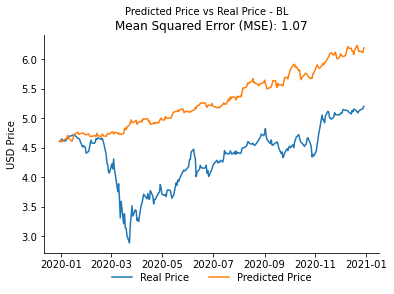

In [73]:
fig, ax = pyplt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pyplt.suptitle('Predicted Price vs Real Price - BL', fontsize=10)
pyplt.title('Mean Squared Error (MSE): {}'.format(np.round(mse, 2)))
pyplt.ylabel('USD Price')
pyplt.plot(final_df)
pyplt.legend(['Real Price', 'Predicted Price'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
pyplt.show()

[Text(0.5, 1.0, 'Forecasting BL Portfolio Price (GBM - 253 Days)'),
 Text(0.5, 0, 'Days from moment of prediction'),
 Text(0, 0.5, 'Portfolio Price')]

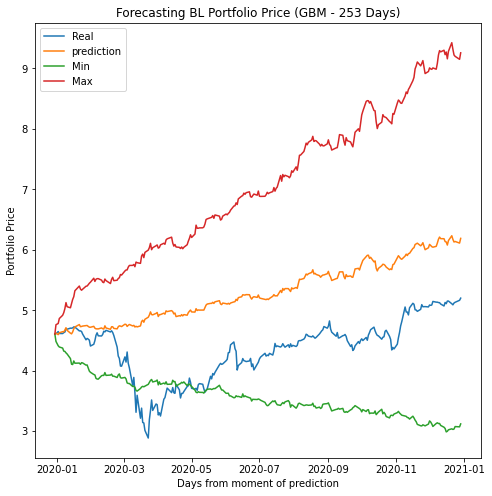

In [74]:
fig, ax = pyplt.subplots(figsize=(8,8)) # width & height 
ax.plot(final_df['real'], label = "Real")
ax.plot(final_df['pred'], label = "prediction")
ax.plot(full_df['Min'], label = "Min")
ax.plot(full_df['Max'], label = "Max")
pyplt.legend()
ax.set(title="Forecasting BL Portfolio Price (GBM - 253 Days)", xlabel="Days from moment of prediction", ylabel="Portfolio Price")

In [49]:
print(N)

262.0


[*********************100%***********************]  48 of 48 completed


3.9565306003265532

0.008152405549268915
0.08564932065407772


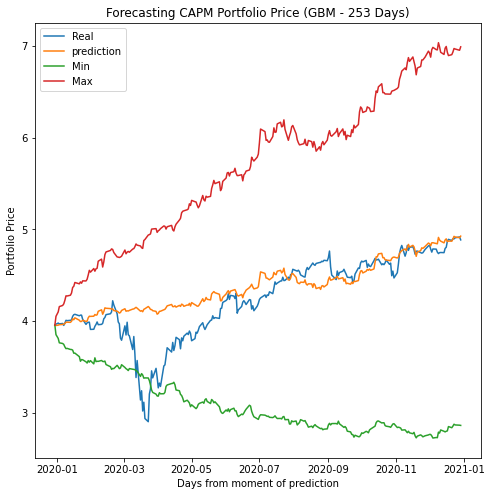

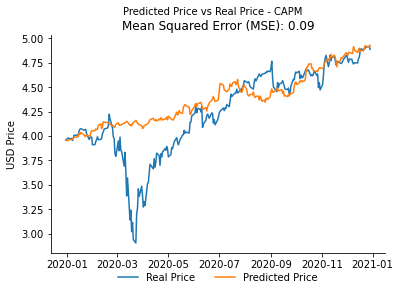

In [69]:
weights = CAPM_Weights
data = yf.download(list(weights.index), start = start, end = future_end, threads = False)
data = data.loc[:,('Close', slice(None))]
data.columns = list(weights.index)

for col in data.columns:
    data.loc[:,col] *= weights.loc[col].values

data = pd.DataFrame(data.mean(axis=1))  
data.columns = ["Close"]
train_set = data.loc[:end]
test_set = data.loc[end:future_end]
daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]

So = train_set.iloc[-1].values[0]
display(So)
dt = 1  # day   # User input
n_of_wkdays = pd.date_range(start=pd.to_datetime(end,format="%Y-%m-%d") + pd.Timedelta('1 days'),end=pd.to_datetime(future_end,
                                               format="%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1, 6) else 0).sum()


T = n_of_wkdays
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(daily_returns)
sigma = np.std(daily_returns)
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, num_simulations + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, num_simulations + 1)}

# Calculating drift and diffusion components
mu = mu.values[0]
sigma = sigma.values[0]
print(sigma)

drift = (mu - 0.5 * sigma ** 2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, num_simulations + 1)}

S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, num_simulations + 1)])
S = np.hstack((np.array([[So] for scen in range(num_simulations)]), S))  # add So to the beginning series
S_max = [S[:, i].max() for i in range(0, int(N))]
S_min = [S[:, i].min() for i in range(0, int(N))]
S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)
final_df = pd.DataFrame(data=[test_set.reset_index()['Close'], S_pred],
                        index=['real', 'pred']).T
final_df.index = test_set.index

S_max = [S[:, i].max() for i in range(0, 253)]
S_min = [S[:, i].min() for i in range(0, 253)]
full_df = pd.DataFrame(data=[S_min, S_max], index=['Min', 'Max']).T
full_df.index = test_set.index

mse = 1/len(final_df) * np.sum((final_df['pred'] - final_df['real']) ** 2)
print(mse)


fig, ax = pyplt.subplots(figsize=(8,8)) # width & height 
ax.plot(final_df['real'], label = "Real")
ax.plot(final_df['pred'], label = "prediction")
ax.plot(full_df['Min'], label = "Min")
ax.plot(full_df['Max'], label = "Max")
pyplt.legend()
ax.set(title="Forecasting CAPM Portfolio Price (GBM - 253 Days)", xlabel="Days from moment of prediction", ylabel="Portfolio Price")
pyplt.show()

fig, ax = pyplt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pyplt.suptitle('Predicted Price vs Real Price - CAPM', fontsize=10)
pyplt.title('Mean Squared Error (MSE): {}'.format(np.round(mse, 2)))
pyplt.ylabel('USD Price')
pyplt.plot(final_df)
pyplt.legend(['Real Price', 'Predicted Price'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
pyplt.show()


[*********************100%***********************]  48 of 48 completed


4.815160372979182

0.008661903297691781
0.7665479565494671


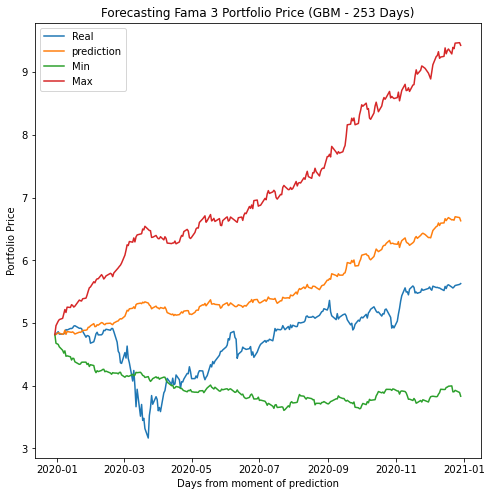

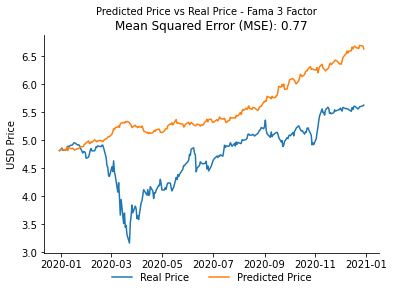

In [67]:
weights = F3_Weights
data = yf.download(list(weights.index), start = start, end = future_end, threads = False)
data = data.loc[:,('Close', slice(None))]
data.columns = list(weights.index)

for col in data.columns:
    data.loc[:,col] *= weights.loc[col].values

data = pd.DataFrame(data.mean(axis=1))  
data.columns = ["Close"]
train_set = data.loc[:end]
test_set = data.loc[end:future_end]
daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]

So = train_set.iloc[-1].values[0]
display(So)
dt = 1  # day   # User input
n_of_wkdays = pd.date_range(start=pd.to_datetime(end,format="%Y-%m-%d") + pd.Timedelta('1 days'),end=pd.to_datetime(future_end,
                                               format="%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1, 6) else 0).sum()


T = n_of_wkdays
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(daily_returns)
sigma = np.std(daily_returns)
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, num_simulations + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, num_simulations + 1)}

# Calculating drift and diffusion components
mu = mu.values[0]
sigma = sigma.values[0]
print(sigma)

drift = (mu - 0.5 * sigma ** 2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, num_simulations + 1)}

S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, num_simulations + 1)])
S = np.hstack((np.array([[So] for scen in range(num_simulations)]), S))  # add So to the beginning series
S_max = [S[:, i].max() for i in range(0, int(N))]
S_min = [S[:, i].min() for i in range(0, int(N))]
S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)
final_df = pd.DataFrame(data=[test_set.reset_index()['Close'], S_pred],
                        index=['real', 'pred']).T
final_df.index = test_set.index

S_max = [S[:, i].max() for i in range(0, 253)]
S_min = [S[:, i].min() for i in range(0, 253)]
full_df = pd.DataFrame(data=[S_min, S_max], index=['Min', 'Max']).T
full_df.index = test_set.index

mse = 1/len(final_df) * np.sum((final_df['pred'] - final_df['real']) ** 2)
print(mse)


fig, ax = pyplt.subplots(figsize=(8,8)) # width & height 
ax.plot(final_df['real'], label = "Real")
ax.plot(final_df['pred'], label = "prediction")
ax.plot(full_df['Min'], label = "Min")
ax.plot(full_df['Max'], label = "Max")
pyplt.legend()
ax.set(title="Forecasting Fama 3 Portfolio Price (GBM - 253 Days)", xlabel="Days from moment of prediction", ylabel="Portfolio Price")
pyplt.show()

fig, ax = pyplt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pyplt.suptitle('Predicted Price vs Real Price - Fama 3 Factor', fontsize=10)
pyplt.title('Mean Squared Error (MSE): {}'.format(np.round(mse, 2)))
pyplt.ylabel('USD Price')
pyplt.plot(final_df)
pyplt.legend(['Real Price', 'Predicted Price'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
pyplt.show()

[*********************100%***********************]  48 of 48 completed


4.81368217179088

0.008667160275100392
0.6526858381929262


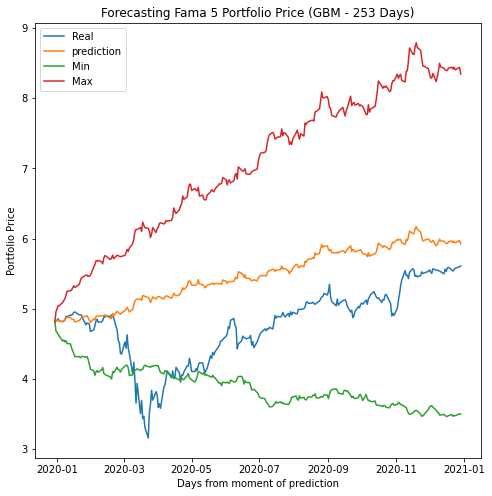

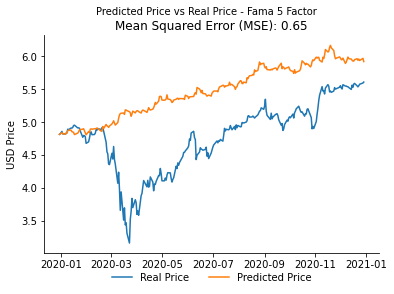

In [65]:
weights = F5_Weights
data = yf.download(list(weights.index), start = start, end = future_end, threads = False)
data = data.loc[:,('Close', slice(None))]
data.columns = list(weights.index)

for col in data.columns:
    data.loc[:,col] *= weights.loc[col].values

data = pd.DataFrame(data.mean(axis=1))  
data.columns = ["Close"]
train_set = data.loc[:end]
test_set = data.loc[end:future_end]
daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]

So = train_set.iloc[-1].values[0]
display(So)
dt = 1  # day   # User input
n_of_wkdays = pd.date_range(start=pd.to_datetime(end,format="%Y-%m-%d") + pd.Timedelta('1 days'),end=pd.to_datetime(future_end,
                                               format="%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1, 6) else 0).sum()


T = n_of_wkdays
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(daily_returns)
sigma = np.std(daily_returns)
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, num_simulations + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, num_simulations + 1)}

# Calculating drift and diffusion components
mu = mu.values[0]
sigma = sigma.values[0]
print(sigma)

drift = (mu - 0.5 * sigma ** 2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, num_simulations + 1)}

S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, num_simulations + 1)])
S = np.hstack((np.array([[So] for scen in range(num_simulations)]), S))  # add So to the beginning series
S_max = [S[:, i].max() for i in range(0, int(N))]
S_min = [S[:, i].min() for i in range(0, int(N))]
S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)
final_df = pd.DataFrame(data=[test_set.reset_index()['Close'], S_pred],
                        index=['real', 'pred']).T
final_df.index = test_set.index

S_max = [S[:, i].max() for i in range(0, 253)]
S_min = [S[:, i].min() for i in range(0, 253)]
full_df = pd.DataFrame(data=[S_min, S_max], index=['Min', 'Max']).T
full_df.index = test_set.index

mse = 1/len(final_df) * np.sum((final_df['pred'] - final_df['real']) ** 2)
print(mse)


fig, ax = pyplt.subplots(figsize=(8,8)) # width & height 
ax.plot(final_df['real'], label = "Real")
ax.plot(final_df['pred'], label = "prediction")
ax.plot(full_df['Min'], label = "Min")
ax.plot(full_df['Max'], label = "Max")
pyplt.legend()
ax.set(title="Forecasting Fama 5 Portfolio Price (GBM - 253 Days)", xlabel="Days from moment of prediction", ylabel="Portfolio Price")
pyplt.show()

fig, ax = pyplt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pyplt.suptitle('Predicted Price vs Real Price - Fama 5 Factor', fontsize=10)
pyplt.title('Mean Squared Error (MSE): {}'.format(np.round(mse, 2)))
pyplt.ylabel('USD Price')
pyplt.plot(final_df)
pyplt.legend(['Real Price', 'Predicted Price'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
pyplt.show()

[*********************100%***********************]  48 of 48 completed


4.927478141605509

0.009139130256147723
1.3042997090162096


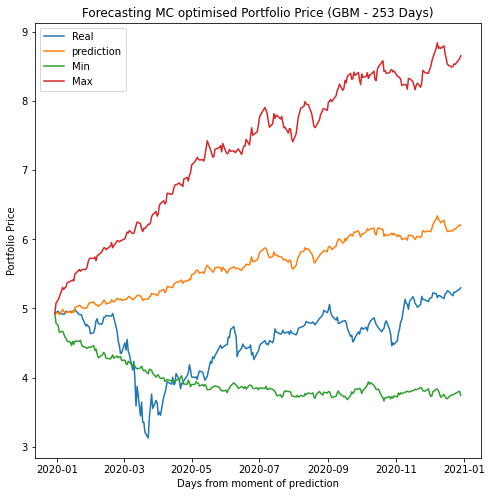

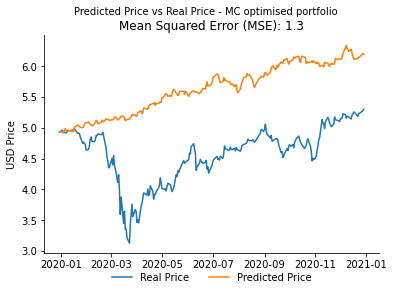

In [75]:
weights = MC_Weights
data = yf.download(list(weights.index), start = start, end = future_end, threads = False)
data = data.loc[:,('Close', slice(None))]
data.columns = list(weights.index)

for col in data.columns:
    data.loc[:,col] *= weights.loc[col].values

data = pd.DataFrame(data.mean(axis=1))  
data.columns = ["Close"]
train_set = data.loc[:end]
test_set = data.loc[end:future_end]
daily_returns = ((train_set / train_set.shift(1)) - 1)[1:]

So = train_set.iloc[-1].values[0]
display(So)
dt = 1  # day   # User input
n_of_wkdays = pd.date_range(start=pd.to_datetime(end,format="%Y-%m-%d") + pd.Timedelta('1 days'),end=pd.to_datetime(future_end,
                                               format="%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1, 6) else 0).sum()


T = n_of_wkdays
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(daily_returns)
sigma = np.std(daily_returns)
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, num_simulations + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, num_simulations + 1)}

# Calculating drift and diffusion components
mu = mu.values[0]
sigma = sigma.values[0]
print(sigma)

drift = (mu - 0.5 * sigma ** 2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, num_simulations + 1)}

S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, num_simulations + 1)])
S = np.hstack((np.array([[So] for scen in range(num_simulations)]), S))  # add So to the beginning series
S_max = [S[:, i].max() for i in range(0, int(N))]
S_min = [S[:, i].min() for i in range(0, int(N))]
S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)
final_df = pd.DataFrame(data=[test_set.reset_index()['Close'], S_pred],
                        index=['real', 'pred']).T
final_df.index = test_set.index

S_max = [S[:, i].max() for i in range(0, 253)]
S_min = [S[:, i].min() for i in range(0, 253)]
full_df = pd.DataFrame(data=[S_min, S_max], index=['Min', 'Max']).T
full_df.index = test_set.index

mse = 1/len(final_df) * np.sum((final_df['pred'] - final_df['real']) ** 2)
print(mse)


fig, ax = pyplt.subplots(figsize=(8,8)) # width & height 
ax.plot(final_df['real'], label = "Real")
ax.plot(final_df['pred'], label = "prediction")
ax.plot(full_df['Min'], label = "Min")
ax.plot(full_df['Max'], label = "Max")
pyplt.legend()
ax.set(title="Forecasting MC optimised Portfolio Price (GBM - 253 Days)", xlabel="Days from moment of prediction", ylabel="Portfolio Price")
pyplt.show()

fig, ax = pyplt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pyplt.suptitle('Predicted Price vs Real Price - MC optimised portfolio', fontsize=10)
pyplt.title('Mean Squared Error (MSE): {}'.format(np.round(mse, 2)))
pyplt.ylabel('USD Price')
pyplt.plot(final_df)
pyplt.legend(['Real Price', 'Predicted Price'], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
pyplt.show()

1.3042997090162096
